# Shape Modelling

#### Marcel Lüthi, Department of Mathematics and Computer Science, University of Basel 

In this notebook we will apply the same techniques, that we developed for the simple regression model, to shape models. 
In particular, we will learn how to use the shape model as a prior, and how to generate contours. This will then allow us to build a generative model of 2D contours generated from vertebra shapes. 

### Setup

We start again by suppressing excessive outputs from the jupyter-kernel and by doing the necessary imports that we need. 
This time, we import [Scalismo](https://www.scalismo.org), an open-source library for shape modelling. 

In [1]:
// Suppressing excessive output for the jupyter-notebook
val api = implicitly[almond.api.JupyterApi]
api.silent(true)

api: JupyterApi = almond.JupyterApiImpl@2fe81c8c

In [2]:
// add repository from which the libraries are loaded
import coursierapi.{Credentials, MavenRepository}
interp.repositories() ++= Seq(
  MavenRepository.of("https://oss.sonatype.org/content/repositories/snapshots")
)


In [3]:
// load necessary libraries
import $ivy.`ch.unibas.cs.gravis::scalismo-plot:0.1-SNAPSHOT`
import $ivy.`ch.unibas.cs.gravis::scalismo-renderer:0.1-SNAPSHOT`
import $ivy.`org.scalanlp::breeze:2.1.0`
import $ivy.`org.scalanlp::breeze-natives:2.1.0`

In [4]:
// imports needed in the program 

// plotting functionality
import scalismo.plot.data.DataFrame
import scalismo.plot.plottarget.PlotTarget.plotTargetJupyter

// basic scalismo datastructures and rendering
import scalismo.mesh.{LineMesh, TriangleMesh}
import scalismo.geometry.*
import scalismo.common.PointId
import scalismo.io.StatisticalModelIO
import scalismo.renderer.{Renderer, ContourRenderer}
import scalismo.renderer.show
import scalismo.transformations.*
import scalismo.color.RGB

// linear algebra and statistics
import breeze.stats.distributions.Rand.FixedSeed.randBasis
import breeze.linalg.{DenseMatrix, DenseVector, linspace}
import breeze.stats.distributions.*


// helpers from java
import java.lang.Math
import java.io.File

Scalismo requires that we define an instance to a random number generator. 

In [5]:
given rng : scalismo.utils.Random = scalismo.utils.Random(42L)

### Loading and sampling from a model 

We start by loading a statistical shape model in Scalismo. 

In [6]:
val vertebraModel = StatisticalModelIO.readStatisticalTriangleMeshModel3D(File("./data/vertebra-model.h5")).get 

Let's render the mean shape:

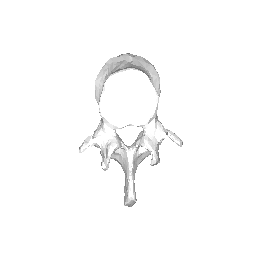

In [12]:
def render(mesh : TriangleMesh[_3D]) : Unit = 
    Renderer.renderMesh(mesh, RGB.White, Point3D(0, 0, 300), 256, 256).show()

render(vertebraModel.mean)

The model represents vertebra shapes (Triangle meshses), which have its center of mass located at the origin, as we can easily check:

In [13]:
println(vertebraModel.mean.pointSet.centerOfMass)

Point3D(1.2721868870857467E-9,1.9285520111433918E-8,-1.4552223375971507E-8)


### Shape space

The model does not only represent the mean shape, but a continuous space of shapes. 
Each shape in this space is represented by a coefficient vector $\alpha=(\alpha_1, \ldots, \alpha_r)$. A shape itself, consisting of a set of points 
$(x_1, \ldots, x_n) \subset \mathbb{R}^3$ is given by the following expansion:

$x_i = x_i^R + \mu(x_i^R) + \sum_{i=1}^r \alpha_i \Phi_i(x_i^R)$

where $x_i^R$ is the point corresponding to $x_i$ on a given reference shape, $\alpha_i$ is a coefficient (or coordinate) and $\Phi_i$ a basis-function. By varying the coefficients $\alpha_i$ we can generate different shapes.  

In [16]:
// the shape with the coefficient vector (3, 0, 0, ..., 0)
val alpha= DenseVector.zeros[Double](vertebraModel.rank)
alpha(0) = 3

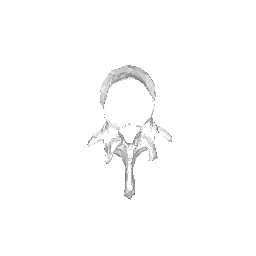

In [17]:
render(vertebraModel.instance(alpha))

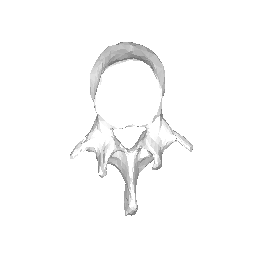

In [18]:
// the shape with the coefficient vector (-3, 0, 0, ..., 0)
alpha(0)= -3
render(vertebraModel.instance(alpha))

### Priors for shape

Not all shapes are equally likely. A common assumption in shape modelling is, that the coefficients $\alpha_1, \ldots, \alpha_n$, follow a normal distribution, I.e. $\alpha_i \sim N(0, 1)$. This means we can sample from it by drawing random coefficients. 

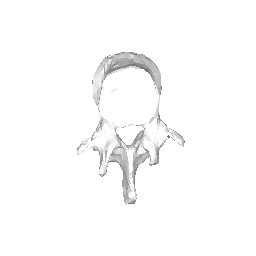

In [19]:
val alpha = MultivariateGaussian(DenseVector.zeros[Double](vertebraModel.rank), DenseMatrix.eye[Double](vertebraModel.rank)).draw()
val sample = vertebraModel.instance(alpha)
render(sample)

This functionality is already built into scalismo in its sample method. We can thus generate samples using the following, simpler, code:

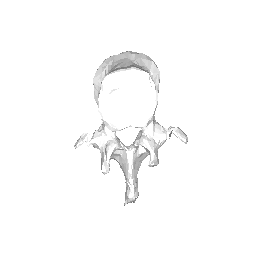

In [12]:
val sample = vertebraModel.sample()
render(sample)

#### Exercises:

* Create very unlikely shapes by manually setting some coefficient values to a very large value
* Sample a few shapes randomly and obsserve the variation
* Can you find out what variations do the individual components represent by varying the value of their respective coefficient
* Can you plot a distribution of the surface area of vertebra shapes? To get the area of the vertebra, you can use the method `area` on a sampled mesh.
* Think about how this connects to the prior predictive plots we performed for the toy problem. Can you think of other plots that could be useful to understand if this is a good shape prior? You may find the following code snippets useful.

### Rendering a contour

Our goal in the projet is to be able to explain a contour in an image. To this end, we simulate the following, simple X-ray setup:
![x-ray-setup](images/xray-setup.png)

Placing an object between the x-ray source and the sensorplane will result in a 2D image. In our simulation, the object is a mesh, which models only the boundary of the object, the resulting image will only show the projected mesh contours. 

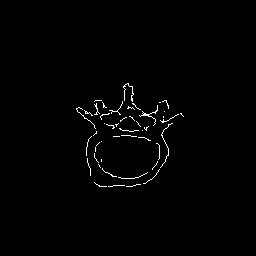

In [20]:
val mesh = vertebraModel.sample()
val sensorDistance = 100
val sourceLocation = Point3D(0, 0, 80 )
val meshContour : LineMesh[_2D] = ContourRenderer.projectMeshContours(mesh, sensorDistance, sourceLocation)
ContourRenderer.renderMeshContour(meshContour, 256, 256).show()

### The generative model 

With this setup, we can now set up a generative model for the contour $C$:

$p(C, \alpha) = p(C | \alpha)p(\alpha)$

We already know that we model the prior as $p(\alpha_i) \sim N(0, I)$. We can thus generate a shape $\Gamma[\alpha]$ given these coefficients. For the likelihood term $p(C | \alpha)$ we assume that the points of the observed contour $C$ are a noisy version of the generated contour obtained from the projected shape $\Gamma[\alpha]$. This is made precise in the following code:

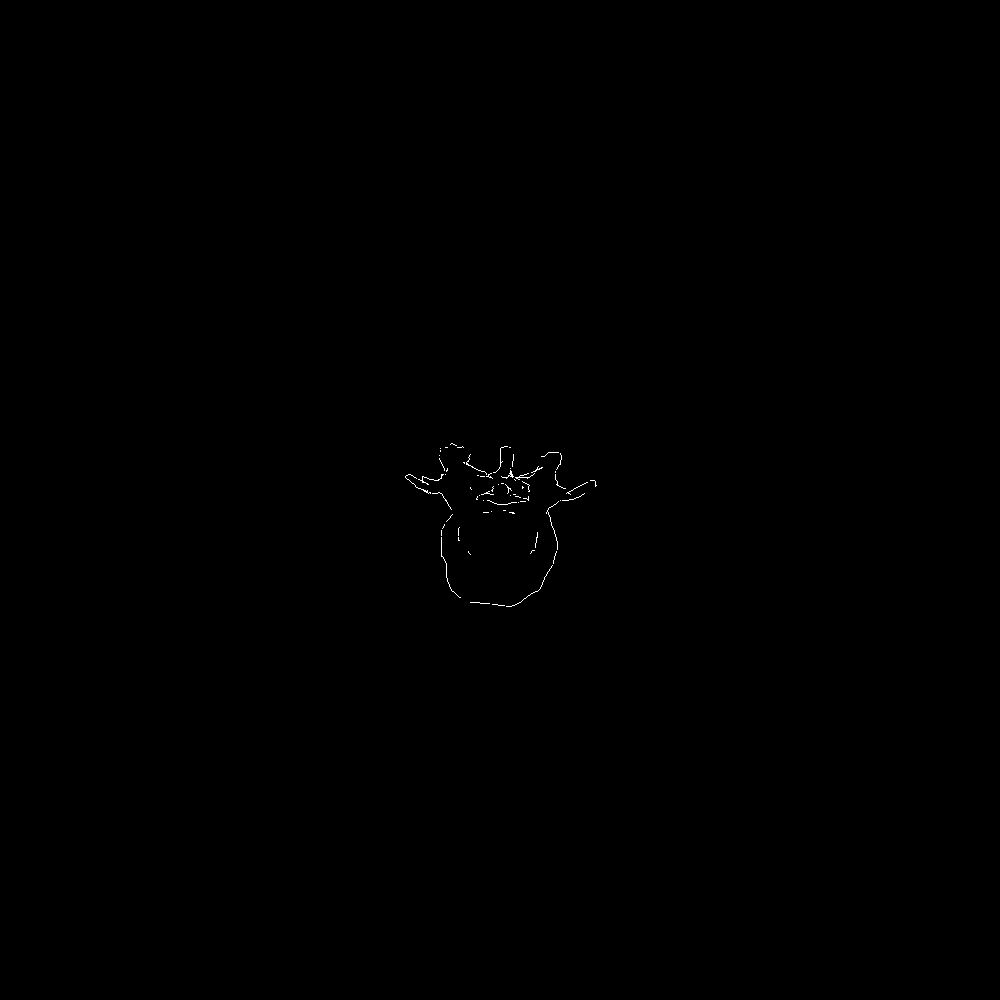

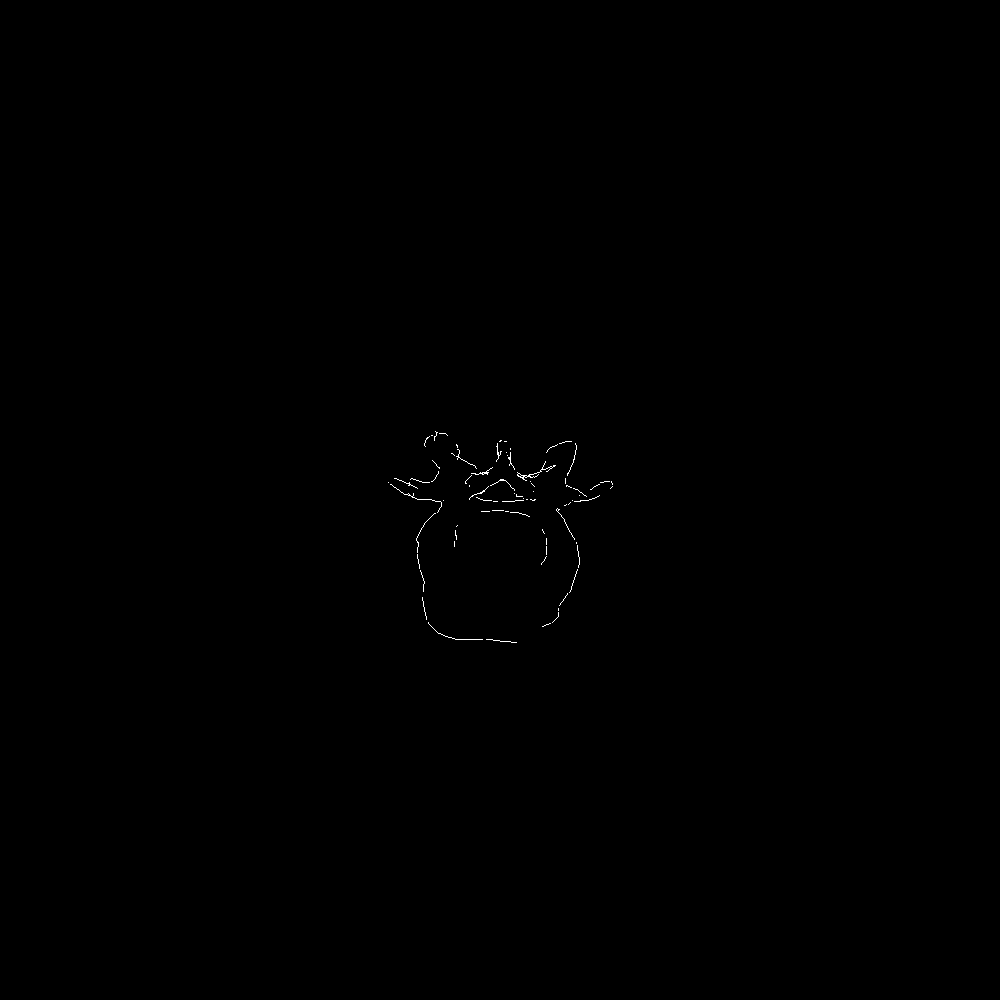

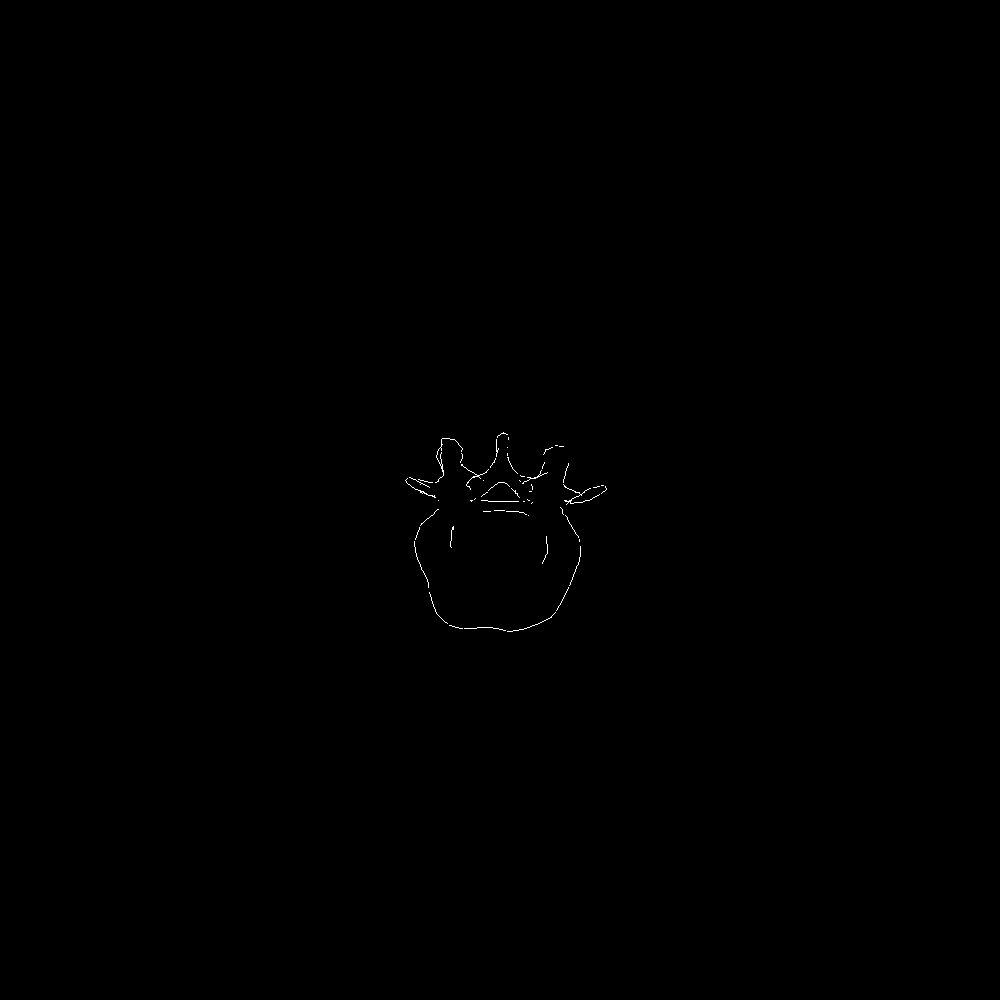

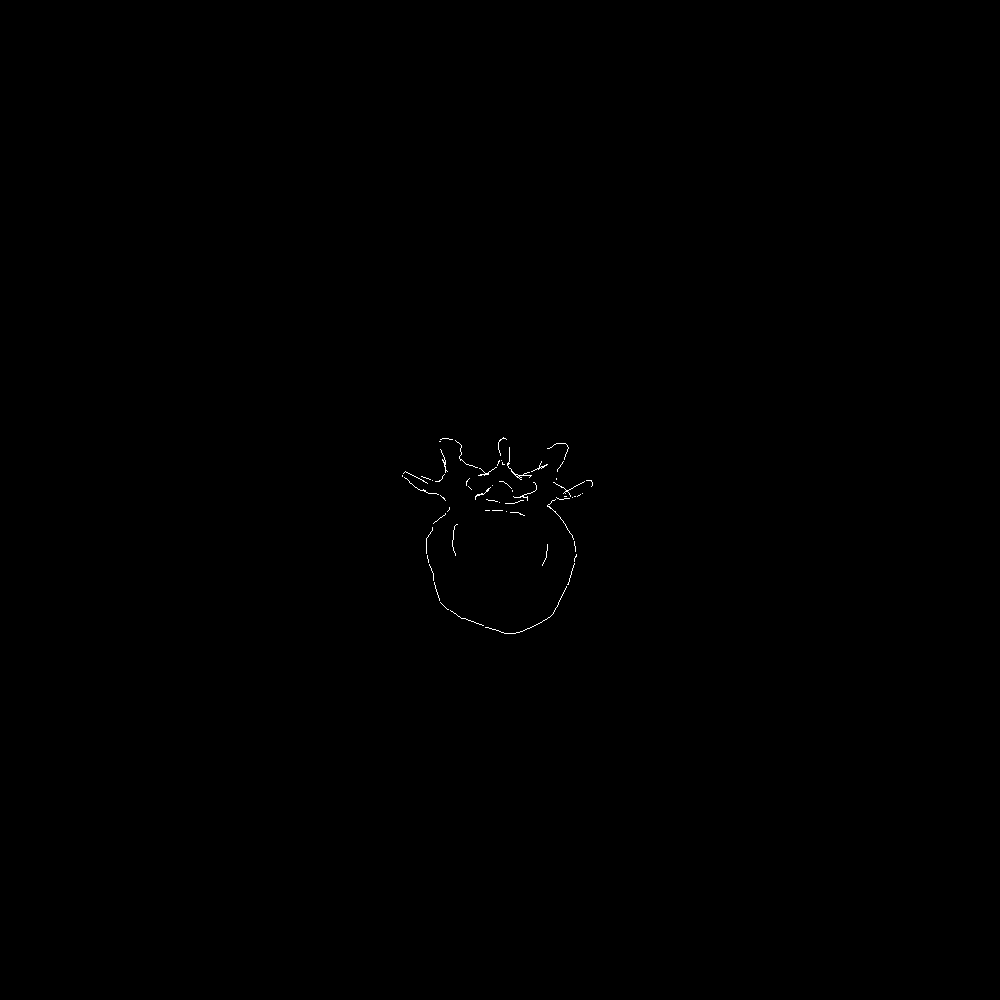

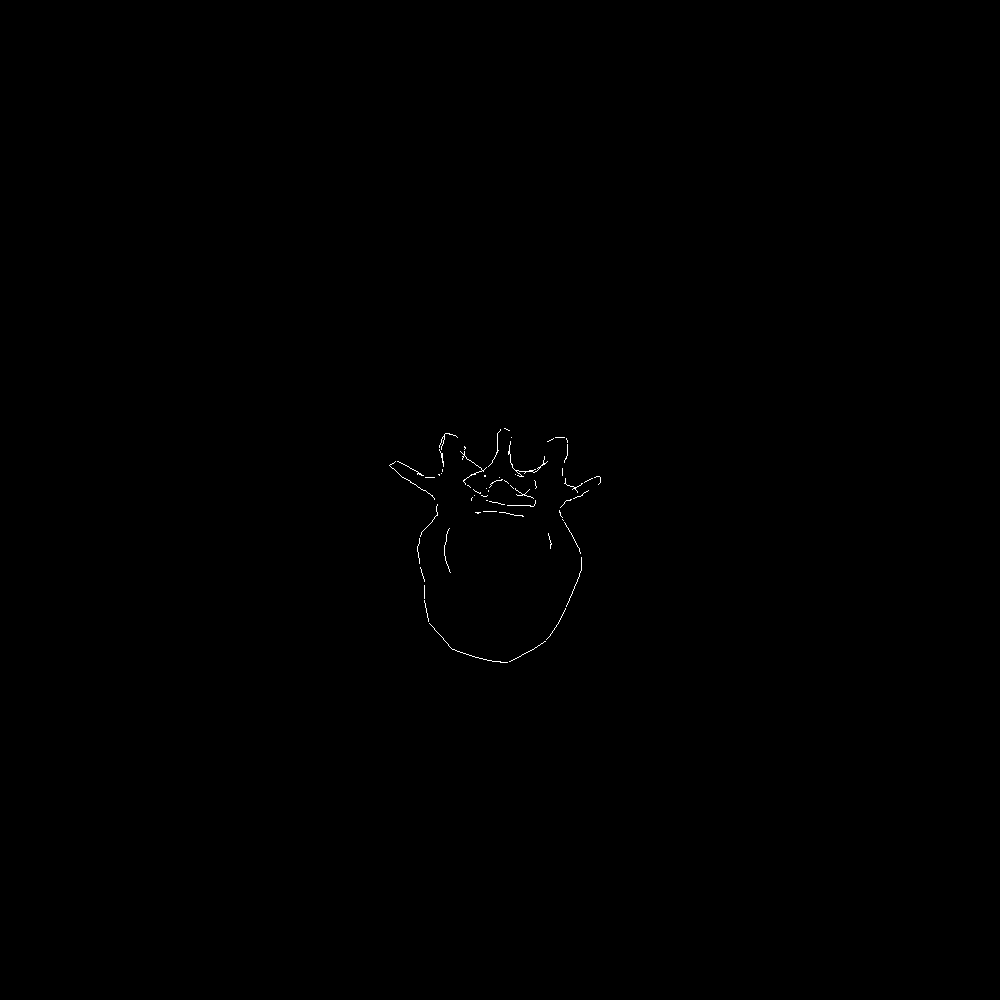

In [21]:
def generate() : LineMesh[_2D] = 

    val sensorDistance = 100
    val sourceLocation = Point3D(0, 0, 50)

    // sample from the prior
    val alpha = MultivariateGaussian(DenseVector.zeros[Double](vertebraModel.rank), DenseMatrix.eye[Double](vertebraModel.rank)).draw()    
    val sample = vertebraModel.instance(alpha)

    // project the sampled shape to get the contour
    val sampledContour = ContourRenderer.projectMeshContours(sample, sensorDistance, sourceLocation)
    
    // add Gaussian noise to each point
    val sigma = 1e-3  
    
    val noiseTransform = Transformation2D( (point : Point[_2D]) => 
            val pointVec = DenseVector(point.x, point.y)
            val noisyPoint = MultivariateGaussian(pointVec, DenseMatrix.eye[Double](2)* sigma).draw()

            Point2D(noisyPoint(0), noisyPoint(1))
        )                 
    sampledContour.transform(noiseTransform)
    


for i <- 0 until 5 do
    val contour = generate()
    ContourRenderer.renderMeshContour(contour, 1000, 1000).show()

### Exercise:

- What are the units of the noise parameter `sigma`. What does it really model? How would you choose it?
- This model considers both the position/pose of the vertebra model as well as the x-ray setup as fixed. Think about if this is realistic for our final goal to reconstruct hand-drawn contours. 
    - Which parameters would you need to add?
    - What would be their prior
- Extend the generate method such that it takes these parameters into account. Perform prior predictive checks to get a feeling for what your prior implies. You may find the following code snippets useful. 


### Useful code snippets

In [15]:
// define transformations
val translation = Translation3D(EuclideanVector3D(10.0, 1.0, 7.0))
val rotation  = Rotation3D(Math.PI / 2, 0, Math.PI / 4, center = Point3D(0, 0, 0))

// define a rigid transformation, which performs first a rotation then a translation
val rigidTransformation = TranslationAfterRotation(translation, rotation)

// we can apply the transformation to any mesh, and get a new mesh 
// that is transformed accordingly (i.e. is at a new position in space
val mesh : TriangleMesh[_3D] = vertebraModel.sample()
val meshAtNewPosition = mesh.transform(rigidTransformation)